# Image Classification of Waste
### Shiyu Murashima
### March 18, 2024

Efficient waste management hinges on precisely categorizing various types of waste such as plastic, metal, or food organics. Classifying waste is usually done by weight and volume inspection, followed by visual or manual sorting. An acquaintance of mine was engaged in analogous research for Sustainability Action Research at UCLA, in which they classified various types of waste in UCLA trash bins through visual and manual sorting, and conducted an extensive analysis of better waste management. This approach of classifying waste, however, is often hindered by subjectivity, scalability issues, and most importantly, the amount of labor required. This eventually peaked my interest in this topic, as I thought that it could be beneficial to automate this process by using machine learning techniques for image classification. This would offer a more objective and scalable alternative. 

The goal of this project is to accurately classify images of waste into its correct category. To do this, I will be using the RealWaste dataset from the UCI Machine Learning Repository, collected by Sam Single, Saeid Iranmanesh, and Raad Raad. This dataset consists of color images of waste items taken upon arrival at a landfill site. Each of the images have a resolution of 524x524 pixels. These waste images are also categorized into 9 different labels: cardboard, food organics, glass, metal, miscellaneous trash, paper, plastic, textile trash, and vegetation.

Data: https://archive.ics.uci.edu/dataset/908/realwaste

Credits: S. Single, S. Iranmanesh, R. Raad, RealWaste, electronic dataset, The UCI Machine Learning Repository, Wollongong City Council, CC BY 4.0

Sam Single, Saeid Iranmanesh, and Raad Raad, who collected this data on waste, created this dataset as apart of an honors thesis researching the performance of convolutional neural networks on authentic waste material when trained on unadulterated objects (separate dataset called DiversionNet), compared to training using real waste materials (RealWaste dataset). The paper focuses solely on the convolutional neural network model, but dives deep into using pre-trained models such as VGG-16, InceptionResNetV2, DenseNet121, InceptionV3, and MobileNetV2 to classify real waste when trained on unadulterated materials, versus when samples are collected at a landfill site. When training on the DiversionNet data, they achieved a classification accuracy of 49.69%, while training on the RealWaste data using the pre-trained InceptionV3 model, they achieved a classification accuracy of 89.19%. With the classification accuracy of the RealWaste data being significantly higher than the DiversionNet data, this consequently revealed the need for sampling training data from a real-life environment to be able to have a classification accuracy greater than a flip of a coin. Therefore, their last suggestion was to consider expanding the RealWaste dataset to account for class imbalance and to train the model with more data.

#### Preprocessing

The RealWaste data was imported via an ImageDataGenerator instance, which helped preprocess and augment each of our images. 
The ImageDataGenerator rescaled pixel values on a range from 0 to 1, assigned a shear angle of 0.2 degrees in counter-clockwise direction, assigned a zoom range of 0.2, and flipped images horizontally at random. This was then used to read the images into Python, with downscaled image sizes of 128x128 pixels, in batches of 32, with a categorical class mode for multi-class classification. 

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory containing data
dataset_dir = 'realwaste-main/RealWaste' # Please change this directory based on where the data is located in your machine

# Define parameters for ImageDataGenerator
batch_size = 32
image_size = (128, 128)  # Resize images (originally 524x524 px)

# Create an ImageDataGenerator instance for preprocessing and data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    shear_range=0.2,        # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.2,         # Random zoom range
    horizontal_flip=True    # Randomly flip inputs horizontally
)

# Create a generator for reading images from the directory
generator = datagen.flow_from_directory(
    dataset_dir,              
    target_size=image_size,   
    batch_size=batch_size,    
    class_mode='categorical', # 'categorical' for multi-class classification
    shuffle=False
)

2024-03-18 16:29:55.516583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4752 images belonging to 9 classes.


After reading in the data, I found that there were 4752 images belonging to the 9 different class labels that were discussed before. Fortunately, there were no missing values to deal with, as the data simply consists of 9 different folders with various counts of images - I will discuss class imbalance shortly after this section. The next step, was to then split the data into training and testing sets; I chose an 80/20 split, following the Pareto principle. This led to a training sample size of 3801 and a testing sample size of 951. Lastly, the data cannot of course just stay as the file names corresponding to the raw images, so I transformed them into numpy arrays with each array consisting of pixel data corresponding to a specific image.

In [2]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

X = generator.filenames
y = generator.classes

# Splitting data into training and testing sets with 80% training and 20% testing
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Extract class labels and filenames from full paths
X_train_class_labels = [filename.split('/')[0] for filename in X_train_filenames]
X_train_filenames = [filename.split('/')[-1] for filename in X_train_filenames]
X_test_class_labels = [filename.split('/')[0] for filename in X_test_filenames]
X_test_filenames = [filename.split('/')[-1] for filename in X_test_filenames]

# Combine class labels and filenames to create X_train as a list of tuples
X_train = list(zip(X_train_class_labels, X_train_filenames))
X_test = list(zip(X_test_class_labels, X_test_filenames))

def load_and_preprocess_images(file_paths, target_size=(128, 128)):
    images = []
    for file_path in file_paths:
        try:
            image = cv2.imread(file_path)
            if image is None:
                raise FileNotFoundError(f"Failed to load image: {file_path}")
            
            image = cv2.resize(image, target_size)
            
            # Remove channel dimension if present
            if len(image.shape) == 3:
                image = np.mean(image, axis=2)
            
            # Append preprocessed image to list
            images.append(image)
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")
    images_array = np.array(images) # Converting to numpy array
    return images_array

X_train = np.array([load_and_preprocess_images([os.path.join(dataset_dir, class_label, filename)]) for class_label, filename in X_train])
X_test = np.array([load_and_preprocess_images([os.path.join(dataset_dir, class_label, filename)]) for class_label, filename in X_test])

# Fixing shape error
X_train = np.squeeze(X_train, axis=1)
X_test = np.squeeze(X_test, axis=1)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training samples: 3801
Testing samples: 951
Training shape: (3801, 128, 128)
Testing shape: (951, 128, 128)


#### Brief Data Exploration

Before jumping into the statistical modeling, I wanted to explore the data briefly, to see what kind of images we are dealing with, and to see if there was any class imbalance in the data. The following function simply takes a sample preprocessed image from each class. We can see items like the tube of a roll of paper towels for the cardboard class, a bottle of alcohol for the glass class, an aluminum can for the metal class, a Pinocchio poster for the paper class, or a palm tree for the vegetation class.

Class: Cardboard


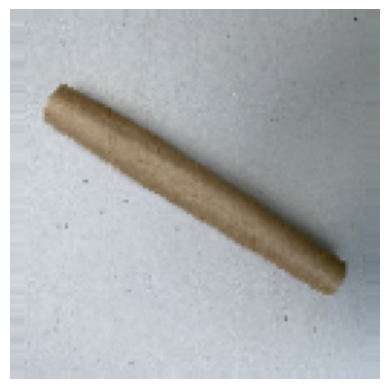

Class: Food Organics


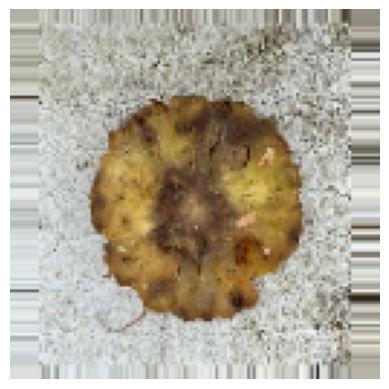

Class: Glass


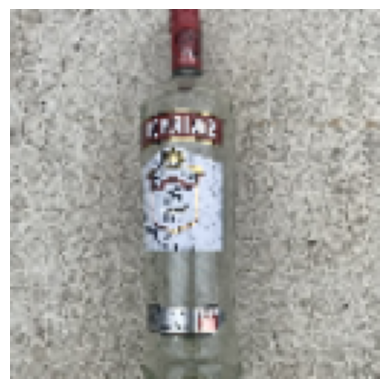

Class: Metal


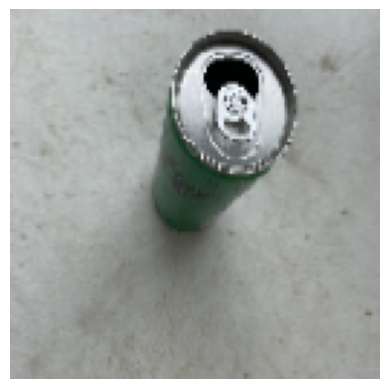

Class: Miscellaneous Trash


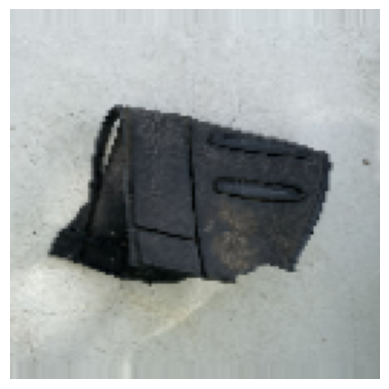

Class: Paper


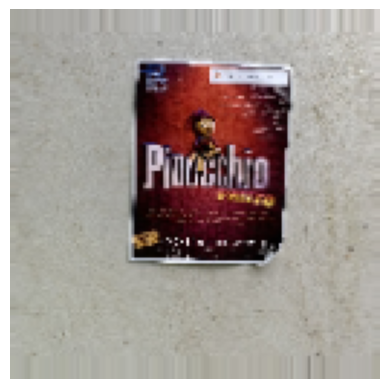

Class: Plastic


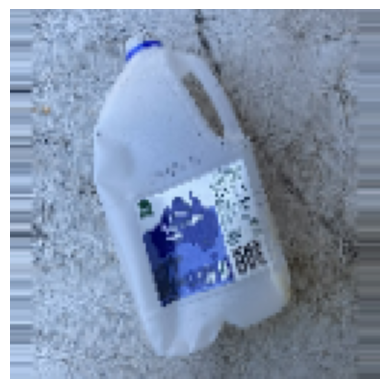

Class: Textile Trash


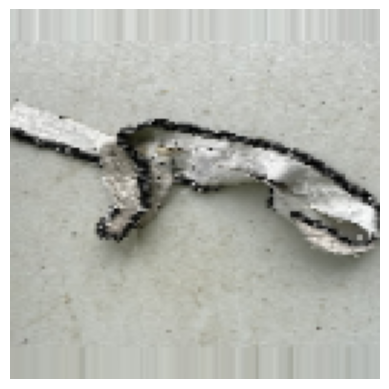

Class: Vegetation


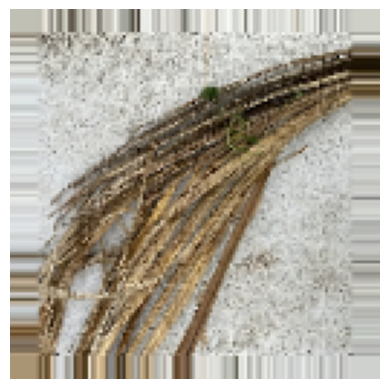

In [3]:
import matplotlib.pyplot as plt

# Function to plot one image from each class
def plot_one_image_per_class(generator):
    class_labels = list(generator.class_indices.keys())
    
    # Create a dictionary to store one image from each class
    one_image_per_class = {label: None for label in class_labels}
    
    # Get a batch of data from the generator
    for _ in range(len(generator)):
        batch = generator.next()
        X_batch, y_batch = batch
        for i in range(len(X_batch)):
            label = np.argmax(y_batch[i])
            if one_image_per_class[class_labels[label]] is None:
                one_image_per_class[class_labels[label]] = X_batch[i]
    
    # Plot one image from each class
    for label, image in one_image_per_class.items():
        print(f"Class: {label}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()

plot_one_image_per_class(generator)

To see if there was any class imbalance in the data, I created a bar plot showing the counts of the images in each class. There is an average of around 400 images in each class, with the exception of the metal class with around 800 images and the plastic class with around 900 images. This suggests that there is imbalance in our data that may potentially lead to bias in our model performance, as the models may prioritize the majority classes and overlook the minority classes. Thus, it is important to keep in mind the imbalance in our data while evaluating the model results. 

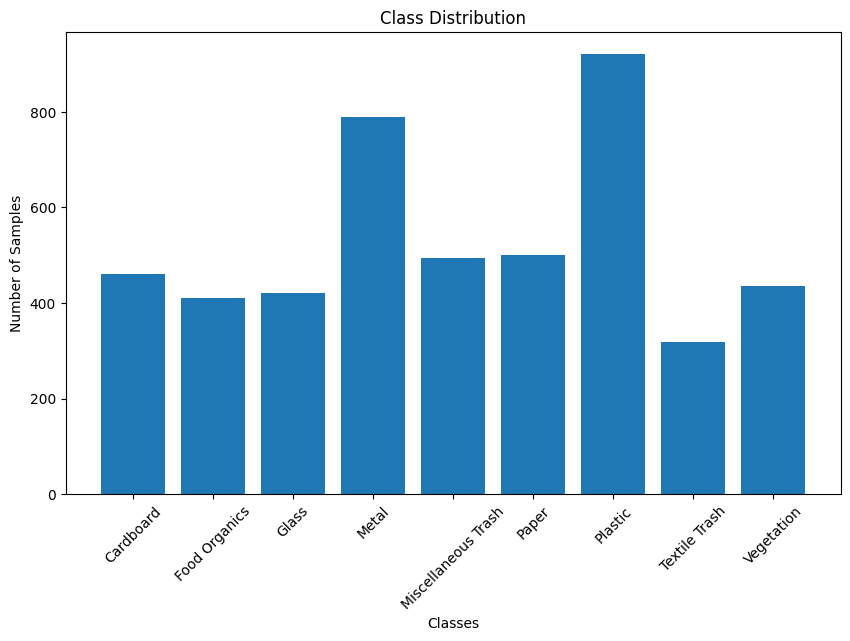

In [4]:
class_labels = list(generator.class_indices.keys())
class_counts = generator.classes # Getting counts of each class

# Calculate the number of samples for each class
class_distribution = {label: np.sum(class_counts == class_labels.index(label)) for label in class_labels}

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#### Statistical Modeling

For my image classification tasks, I will be utilizing logistic regression, naive Bayes, random forest, K-nearest neighbors, support vector machine, XGBoost, and most importantly, dense neural networks and convolutional neural networks.

#### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Normalizing pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshaping data for Logistic Regression/Naive Bayes
X_train_lr_nb = X_train.reshape(-1, 128*128)
X_test_lr_nb = X_test.reshape(-1, 128*128)

# Fit scaler on the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr_nb)
X_test_scaled = scaler.transform(X_test_lr_nb)

# Logistic Regression with scaled data
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_predictions = lr.predict(X_test_scaled)

print("Logistic Regression:")
print(classification_report(y_test, lr_predictions))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.26      0.30      0.28        92
           1       0.34      0.16      0.22        82
           2       0.27      0.58      0.37        84
           3       0.37      0.29      0.32       158
           4       0.14      0.11      0.12        99
           5       0.38      0.42      0.40       100
           6       0.43      0.50      0.46       185
           7       0.13      0.11      0.12        64
           8       0.34      0.14      0.20        87

    accuracy                           0.32       951
   macro avg       0.29      0.29      0.28       951
weighted avg       0.32      0.32      0.30       951



The first model fitted for our image classification task is logistic regression. Logistic regression is a linear classification algorithm generally used for binary classification tasks, but in our case, we will be implementing the algorithm as a multi-class classification task. It models the probability that an instance belongs to a particular class using the logistic function. I first normalized the pixel values for X_train and X_test, reshaped them, and fit a StandardScaler to transform the data. I then fit the logistic regression model using the limited-memory BFGS solver with a maximum of 1000 iterations. This achieved an accuracy of 32%, with a weighted average precision score of 0.32 (how many images are correctly classified per class), a recall of 0.32 (how many of each class you find over the whole number of elements in the respective class), and a f1-score of 0.30 (the harmonic mean between precision and recall).

#### Cross Validation for Logistic Regression

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty = "none", max_iter=1000))
])

# Define the hyperparameters grid
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': [None, 'l2']
}

# Perform grid search
lr_grid_search = GridSearchCV(pipeline, lr_param_grid, cv=2, error_score='raise') # using cv=2 to optimize runtime
lr_grid_search.fit(X_train_lr_nb, y_train)

# Get best parameters and model
best_lr_params = lr_grid_search.best_params_
best_lr_estimator = lr_grid_search.best_estimator_
optimal_lr_predictions = best_lr_estimator.predict(X_test_lr_nb)

print("Optimal hyperparameters:", best_lr_params)
print("Logistic Regression (with optimal hyperparameters):")
print(classification_report(y_test, optimal_lr_predictions))

Optimal hyperparameters: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Logistic Regression (with optimal hyperparameters):
              precision    recall  f1-score   support

           0       0.30      0.32      0.31        92
           1       0.41      0.18      0.25        82
           2       0.30      0.58      0.40        84
           3       0.38      0.38      0.38       158
           4       0.15      0.11      0.13        99
           5       0.44      0.44      0.44       100
           6       0.40      0.56      0.47       185
           7       0.14      0.09      0.11        64
           8       0.45      0.15      0.22        87

    accuracy                           0.35       951
   macro avg       0.33      0.31      0.30       951
weighted avg       0.35      0.35      0.33       951



I then performed a grid search cross validation on the logistic regression to find the optimal hyperparameters for the model. First, I defined a hyperparameter grid with C values of 0.01, 0.1, 1, 10, and 100, with penalty None and L2. The L1 penalty was excluded from the parameters as the solver I used did not support the penalty, hence the warning suppression. Then, I performed the grid search with only two cross validation folds, in order to optimize the runtime. This was a trade-off between computational cost and the quality of the estimate. In the end, the logistic regression results improved slightly after fitting the optimal hyperparameters. This achieved an accuracy of 35%, with a weighted average precision score of 0.35, a recall of 0.35, and f1-score of 0.33.

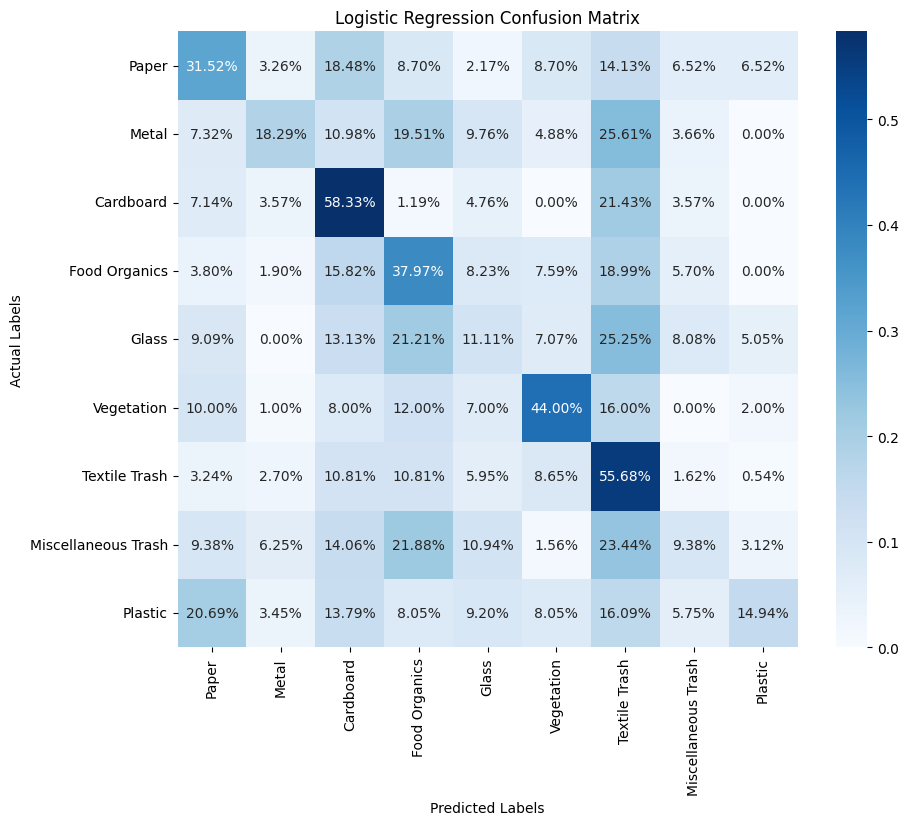

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Paper', 'Metal', 'Cardboard', 'Food Organics', 'Glass', 'Vegetation',
                'Textile Trash', 'Miscellaneous Trash', 'Plastic']

conf_matrix = confusion_matrix(y_test, optimal_lr_predictions) # Get the confusion matrix
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis] # Calculate the percentages
plt.figure(figsize=(10, 8)) # Create a heatmap
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

Lastly, looking at the confusion matrix, we can see that confusion between classes was most significant with miscellaneous trash, followed by glass and plastic. On the other hand, cardboard performed well, along with textile trash.

#### Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_lr_nb, y_train)
nb_predictions = nb.predict(X_test_lr_nb)

print("Naive Bayes:")
print(classification_report(y_test, nb_predictions))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.25      0.36      0.30        92
           1       0.58      0.22      0.32        82
           2       0.29      0.60      0.39        84
           3       0.58      0.39      0.46       158
           4       0.18      0.14      0.16        99
           5       0.42      0.47      0.44       100
           6       0.52      0.39      0.45       185
           7       0.18      0.20      0.19        64
           8       0.45      0.56      0.50        87

    accuracy                           0.38       951
   macro avg       0.38      0.37      0.36       951
weighted avg       0.41      0.38      0.38       951



The second model fitted for our image classification task is naive Bayes. Naive Bayes is a probabilistic classifier based on Bayes' theorem with the "naive" assumption of independence between features. I utilized GaussianNB for this task, and achieved an accuracy of 38%, with a weighted average precision score of 0.41, recall of 0.38, and f1-score of 0.38. 

Additionally, naive Bayes does not have any hyperparameters that require tuning, so I did not perform a cross validation for this model.

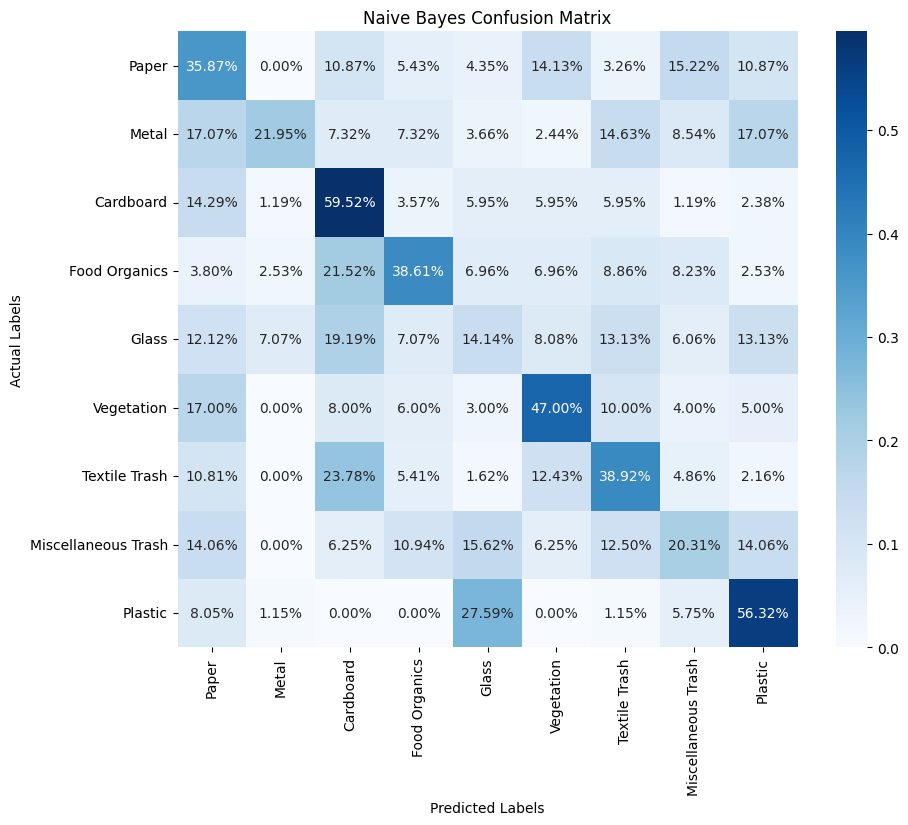

In [9]:
conf_matrix = confusion_matrix(y_test, nb_predictions)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

Looking at the confusion matrix, we can see that for the naive Bayes model, confusion between classes was most prominent with glass, while cardboard performed well again, along with plastic.

#### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_lr_nb, y_train)
rf_predictions = rf.predict(X_test_lr_nb)

print("Random Forest:")
print(classification_report(y_test, rf_predictions))

Random Forest:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52        92
           1       0.57      0.32      0.41        82
           2       0.65      0.52      0.58        84
           3       0.52      0.67      0.59       158
           4       0.39      0.30      0.34        99
           5       0.73      0.56      0.63       100
           6       0.52      0.72      0.60       185
           7       0.62      0.25      0.36        64
           8       0.61      0.84      0.71        87

    accuracy                           0.56       951
   macro avg       0.57      0.52      0.53       951
weighted avg       0.56      0.56      0.54       951



The third model fitted is a random forest using the RandomForestClassifier. Random forest is an ensemble learning method that builds multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. This model achieved a much higher accuracy of 54%, compared to the previous two models of logistic regression and naive Bayes. Additionally, the classification report outputted a weighted average precision score of 0.54, recall of 0.54, and f1-score of 0.52.

#### Cross Validation for Random Forest

In [11]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200] # using estimators 100 and 200
}

# Perform grid search
rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=2, n_jobs=-1) # using cv=2 to optimize runtime
rf_grid_search.fit(X_train_lr_nb, y_train)

best_rf_estimator = rf_grid_search.best_estimator_
best_params = rf_grid_search.best_params_
optimal_rf_predictions = best_rf_estimator.predict(X_test_lr_nb)

print("Optimal hyperparameters:", best_params)
print("Random Forest (with optimal hyperparameters):")
print(classification_report(y_test, optimal_rf_predictions))

Optimal hyperparameters: {'n_estimators': 200}
Random Forest (with optimal hyperparameters):
              precision    recall  f1-score   support

           0       0.61      0.50      0.55        92
           1       0.67      0.27      0.38        82
           2       0.65      0.52      0.58        84
           3       0.48      0.67      0.56       158
           4       0.35      0.24      0.29        99
           5       0.73      0.58      0.65       100
           6       0.52      0.70      0.60       185
           7       0.62      0.20      0.31        64
           8       0.55      0.87      0.68        87

    accuracy                           0.55       951
   macro avg       0.58      0.51      0.51       951
weighted avg       0.56      0.55      0.53       951



Similar to the logistic regression, I then performed a grid search cross validation on the random forest model. First, I defined a hyperparameter grid using 100 and 200 estimators. Then, I performed the grid search using two cross validation folds and -1 number of jobs to again, optimize the run time. The results unfortunately did not change much from the initial model, likely due to the smaller number of estimators and cross validation folds. Nonetheless, this model achieved an accuracy of 55% (1% better than before), a weighted average precision score of 0.55, recall of 0.55, and f1-score of 0.53.

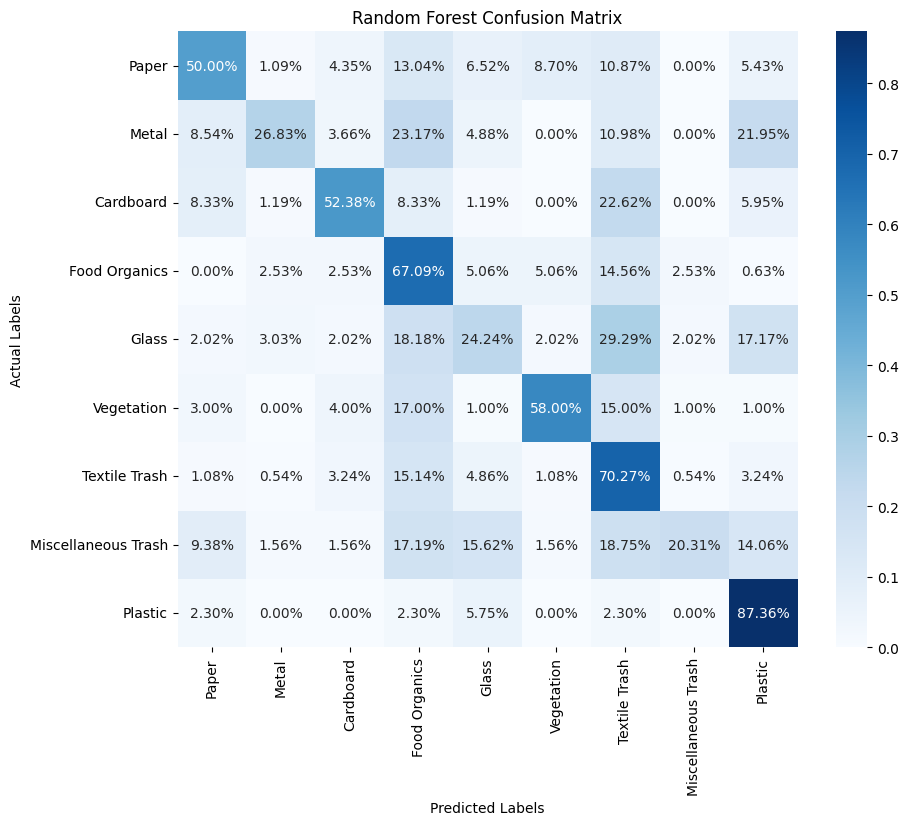

In [12]:
conf_matrix = confusion_matrix(y_test, optimal_rf_predictions)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

From the confusion matrix, we can see that confusion between classes was most significant with miscellaneous trash again, followed by glass. On the other hand, plastic performed extremely well.

#### K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5) # initial model with 5 neighbors
knn_model.fit(X_train_lr_nb, y_train)
knn_predictions = knn_model.predict(X_test_lr_nb)
knn_report = classification_report(y_test, knn_predictions)

print("\nKNN Classification Report:")
print(knn_report)


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.26      0.29        92
           1       0.42      0.10      0.16        82
           2       0.18      0.80      0.29        84
           3       0.50      0.34      0.40       158
           4       0.24      0.27      0.26        99
           5       0.57      0.25      0.35       100
           6       0.38      0.42      0.40       185
           7       0.36      0.06      0.11        64
           8       1.00      0.02      0.04        87

    accuracy                           0.30       951
   macro avg       0.44      0.28      0.26       951
weighted avg       0.44      0.30      0.29       951



The fourth model fitted is a K-nearest neighbors using the KNeighborsClassifier. K-nearest neighbors is a simple and effective classification algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g. Euclidean distance) to the K-nearest neighbors in the training data. This initial model used 5 neighbors, and achieved an accuracy of 30%, which is slightly worse than the logistic regression, a weighted average precision score of 0.44, recall of 0.30, and f1-score of 0.29. 

#### Cross Validation for K-Nearest Neighbors

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters grid
knn_param_dist = {
    'n_neighbors': [3, 5],  # Reduced range to optimize runtime
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Perform randomized search with cross-validation
knn_random_search = RandomizedSearchCV(KNeighborsClassifier(), knn_param_dist, n_iter=4, cv=2, random_state=42) # using cv=2 and n_iter=4 to optimize runtime
knn_random_search.fit(X_train_lr_nb, y_train)

# Get the best parameters and model
best_knn_params = knn_random_search.best_params_
best_knn_estimator = knn_random_search.best_estimator_
optimal_knn_predictions = best_knn_estimator.predict(X_test_lr_nb)

print("Optimal hyperparameters:", best_knn_params)
print("K-Nearest Neighbors (with optimal hyperparameters):")
print(classification_report(y_test, optimal_knn_predictions))

Optimal hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3}
K-Nearest Neighbors (with optimal hyperparameters):
              precision    recall  f1-score   support

           0       0.50      0.46      0.48        92
           1       0.36      0.05      0.09        82
           2       0.25      0.77      0.38        84
           3       0.56      0.47      0.52       158
           4       0.25      0.30      0.27        99
           5       0.60      0.55      0.58       100
           6       0.45      0.52      0.48       185
           7       0.35      0.17      0.23        64
           8       1.00      0.06      0.11        87

    accuracy                           0.40       951
   macro avg       0.48      0.37      0.35       951
weighted avg       0.49      0.40      0.38       951



For my K-nearest neighbors model, I performed a randomized search cross validation, rather than a grid search, to find the optimal hyperparameters for the model. The hyperparameters grid consisted of 3 and 5 neighbors (to optimize runtime), uniform and distance weights, and p values 1 and 2. I then performed the randomized search with 4 iterations and two cross validation folds. This achieved an accuracy of 40% (10% better than the initial), a weighted average precision score of 0.49, recall of 0.40, and f1-score of 0.38.

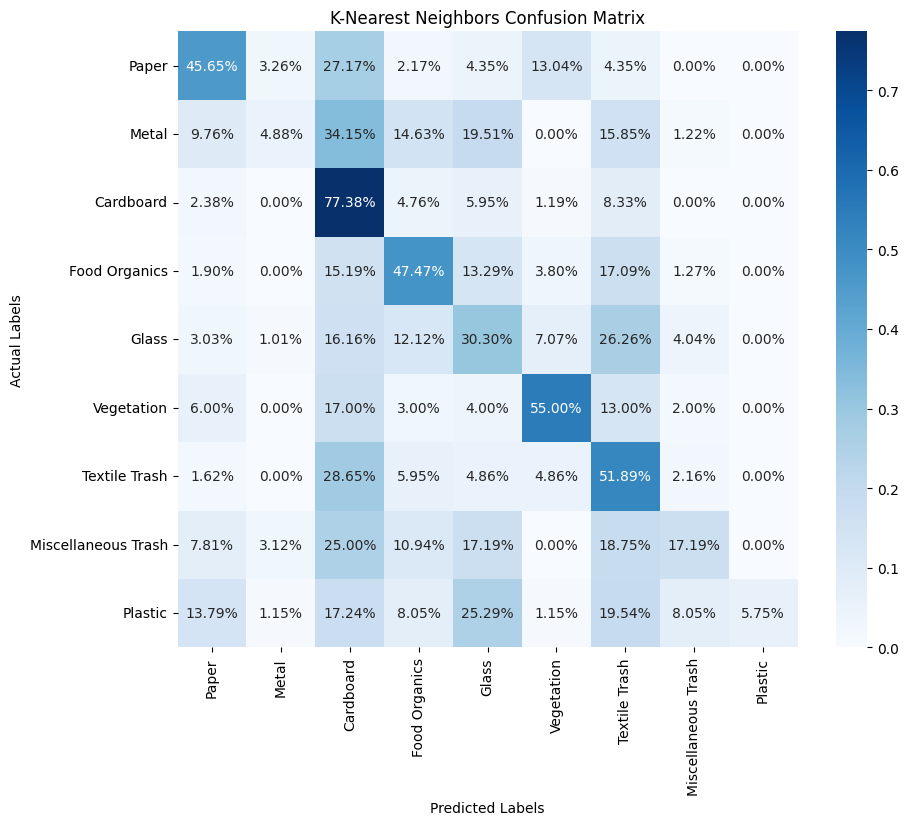

In [16]:
conf_matrix = confusion_matrix(y_test, optimal_knn_predictions)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()

From the confusion matrix, we can see that confusion between classes was very significant with metal, and surprisingly by plastic. On the other hand, cardboard performed well once again.

#### Support Vector Machine

In [17]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_lr_nb, y_train)
svm_predictions = svm_model.predict(X_test_lr_nb)
svm_report = classification_report(y_test, svm_predictions)

print("SVM Classification Report:")
print(svm_report)

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.40      0.43        92
           1       0.57      0.44      0.50        82
           2       0.62      0.56      0.59        84
           3       0.48      0.61      0.54       158
           4       0.38      0.30      0.34        99
           5       0.65      0.49      0.56       100
           6       0.56      0.71      0.62       185
           7       0.38      0.09      0.15        64
           8       0.56      0.82      0.67        87

    accuracy                           0.53       951
   macro avg       0.52      0.49      0.49       951
weighted avg       0.52      0.53      0.51       951



The fifth model fitted is a support vector machine using SVC. Support vector machine is a powerful supervised learning algorithm used for classification. It finds the hyperplane that best separates classes in a high-dimensional space. This model was fitted using a radial basis function kernel which is often used for capturing complex nonlinear relationships, a C value of 1, and a gamma scaled on the number of input features. This achieved an accuracy of 53%, almost as accurate as the random forest, with a weighted average precision score of 0.52, recall of 0.53, and f1-score of 0.51.

In [18]:
# Define the hyperparameters grid
# svm_param_dist = {
#     'C': [0.1, 1],  # Reduced range
#     'gamma': ['scale'],  # Only scale for gamma
#     'kernel': ['linear', 'rbf']  # Only linear and rbf for kernel
# }

# Perform randomized search with cross-validation
# svm_random_search = RandomizedSearchCV(SVC(), svm_param_dist, n_iter=5, cv=2, random_state=42) # using cv=2 and n_iter=5 to optimize runtime
# svm_random_search.fit(X_train_lr_nb, y_train)

# Get the best parameters and model
# best_svm_params = svm_random_search.best_params_
# best_svm_estimator = svm_random_search.best_estimator_
# optimal_svm_predictions = best_svm_estimator.predict(X_test_lr_nb)

# print("Optimal hyperparameters:", best_svm_params)
# print("Support Vector Machine (with optimal hyperparameters):")
# print(classification_report(y_test, optimal_svm_predictions))

I attempted to perform a randomized search cross validation on the support vector machine model, but the runtime was far too long even after tweaking the hyperparameter grid, decreasing the number of iterations, and decreasing the number of cross validation splits. In case you wanted to run the code on a machine with more computational power, I have left my code as a comment.

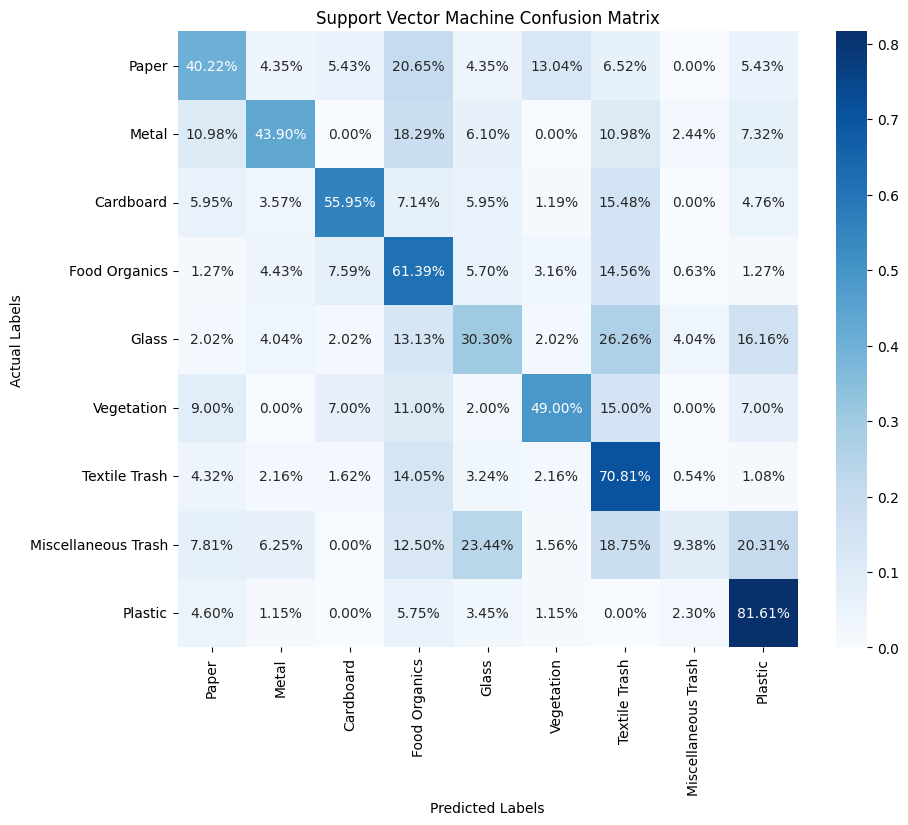

In [19]:
conf_matrix = confusion_matrix(y_test, svm_predictions)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Support Vector Machine Confusion Matrix')
plt.show()

Looking at the confusion matrix, we can see that confusion between classes was very significant with miscellaneous trash only. On the other hand, plastic performed very well, followed by textile trash.

#### XGBoost

In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train_lr_nb, y_train)
xgb_predictions = xgb_model.predict(X_test_lr_nb)
xgb_report = classification_report(y_test, xgb_predictions)

print("\nXGBoost Classification Report:")
print(xgb_report)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.54      0.57        92
           1       0.56      0.41      0.48        82
           2       0.62      0.57      0.60        84
           3       0.58      0.70      0.63       158
           4       0.42      0.27      0.33        99
           5       0.67      0.57      0.62       100
           6       0.55      0.68      0.61       185
           7       0.41      0.27      0.32        64
           8       0.59      0.79      0.68        87

    accuracy                           0.57       951
   macro avg       0.55      0.53      0.54       951
weighted avg       0.56      0.57      0.55       951



The sixth model fitted is a XGBoost model using the XGBClassifier. XGBoost (extreme gradient boosting) is an optimized distributed gradient boosting library designed for efficiency, flexibility, and portability. This model achieved an accuracy of 57%, the best accuracy score so far, with a weighted average precision of 0.56, a recall of 0.57, and f1-score of 0.55.

In [21]:
# Define the hyperparameters grid
# xgb_param_dist = {
#     'n_estimators': [100, 200],  # Reduced range for number of estimators
#     'max_depth': [3, 5],  # Reduced range for max depth
#     'learning_rate': [0.1, 0.01]  # Reduced range for learning rate
# }

# Perform randomized search with cross-validation
# xgb_random_search = RandomizedSearchCV(XGBClassifier(), xgb_param_dist, n_iter=5, cv=2, random_state=42) # using cv=2 and n_iter=5 to optimize runtime
# xgb_random_search.fit(X_train_lr_nb, y_train)

# Get the best parameters and model
# best_xgb_params = xgb_random_search.best_params_
# best_xgb_estimator = xgb_random_search.best_estimator_
# optimal_xgb_predictions = best_xgb_estimator.predict(X_test_lr_nb)

# print("Optimal hyperparameters:", best_xgb_params)
# print("XGBoost (with optimal hyperparameters):")
# print(classification_report(y_test, optimal_xgb_predictions))

I attempted to perform a randomized search cross validation on the XGBoost model as well, but the runtime was too long again. In case you wanted to run the code, I have left my code as a comment.

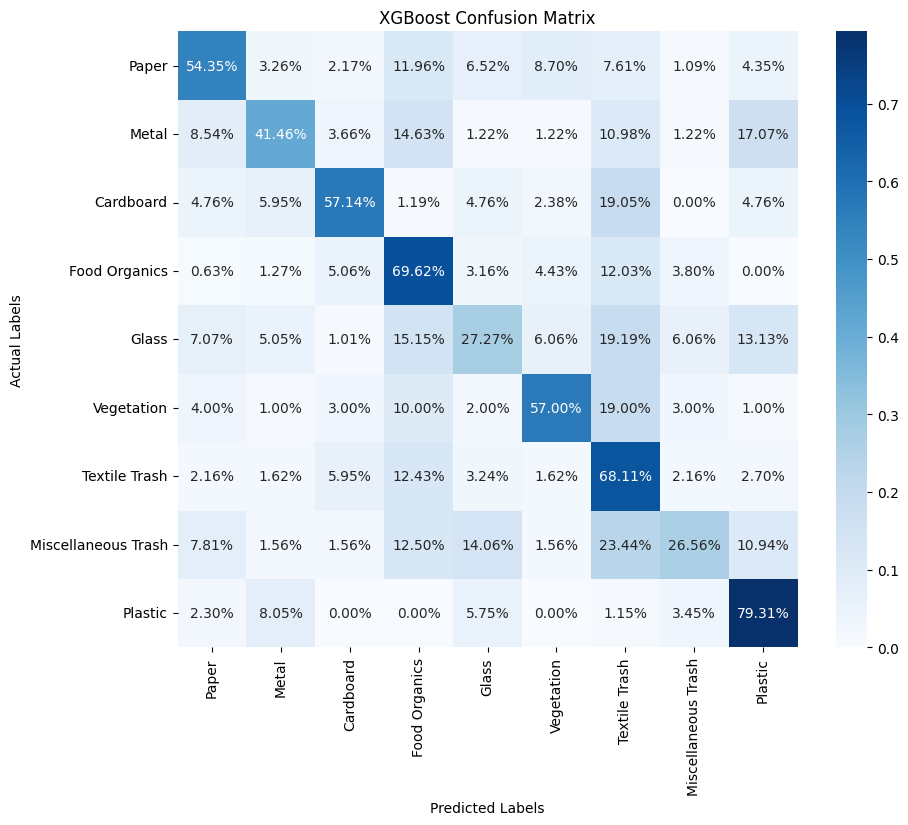

In [22]:
conf_matrix = confusion_matrix(y_test, xgb_predictions)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('XGBoost Confusion Matrix')
plt.show()

Looking at the confusion matrix, we can see that confusion between classes was somewhat prominent with miscellaneous trash and glass, but not as much as the previous models. On the other hand, plastic performed very well once again, followed by food organics and textile trash.

#### Optimizing Hyperparameters for Dense Neural Network

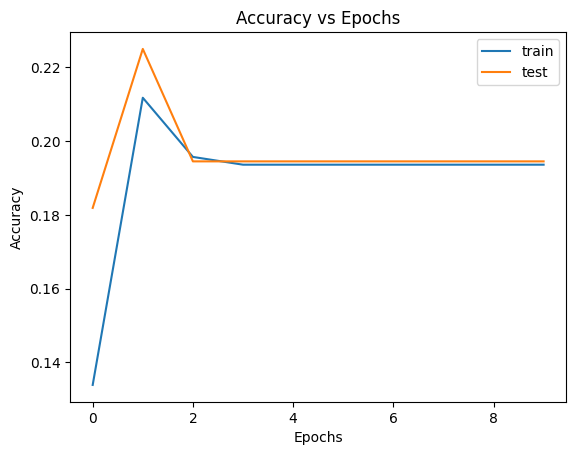

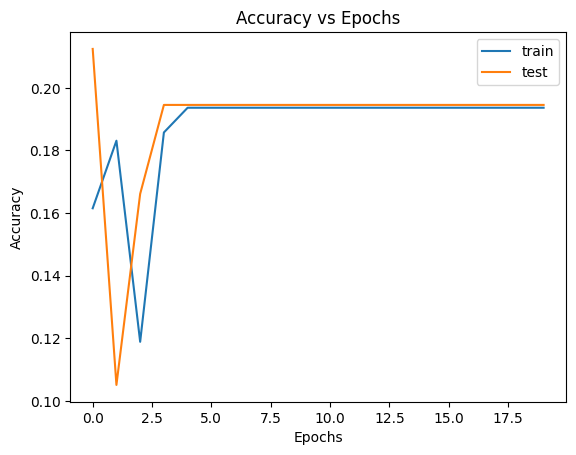

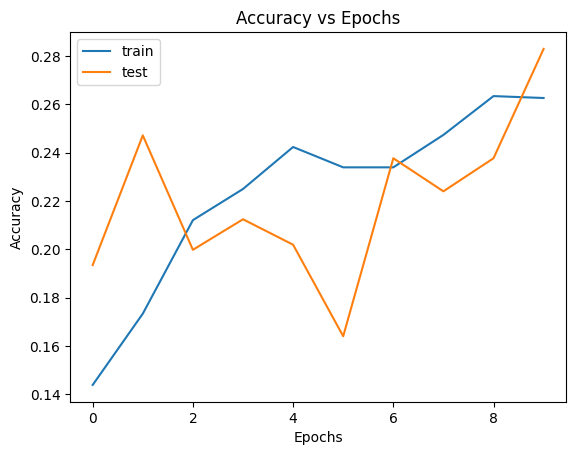

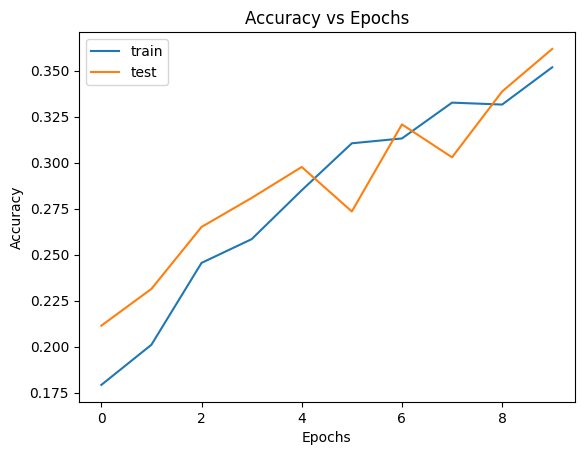

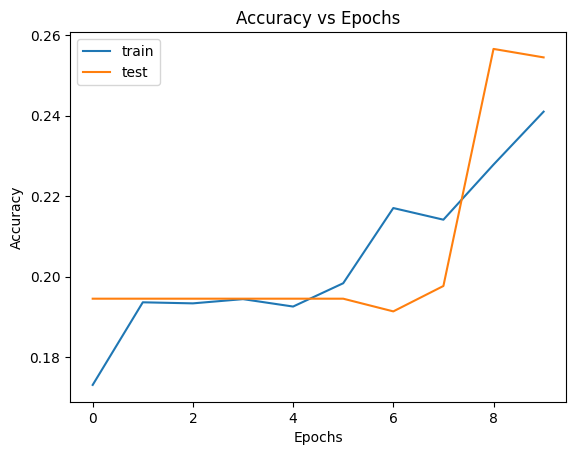

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

tf.random.set_seed(42)

initial_epochs = 10
initial_batch_size = 64
initial_optimizer = 'adam'

# Function for dense neural network
def dnn(num_epochs=initial_epochs, batch_size=initial_batch_size, num_dense_layers=1, optimizer=initial_optimizer):
    model = Sequential() # Create a Sequential model
    model.add(Flatten(input_shape=(128, 128))) # Flatten layer to convert 2D image data to 1D
    for _ in range(num_dense_layers):
        model.add(Dense(80, activation='relu')) # Add Dense layers with ReLU activation
    model.add(Dense(10, activation='softmax'))  # Add the final Dense layer with softmax activation
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    return model, history

initial_dnn_model, initial_history = dnn()

# Plotting accuracy vs epochs
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

# Initial configuration
plot_accuracy(initial_history)

# Changing number of epochs
num_epochs = 20
num_epochs_dnn, num_epochs_history = dnn(num_epochs=num_epochs)
plot_accuracy(num_epochs_history)

# Changing batch size
batch_size = 128
batch_size_dnn, batch_size_history = dnn(batch_size=batch_size)
plot_accuracy(batch_size_history)

# Changing number of dense layers
num_dense_layers = 7
num_dense_layers_dnn, num_dense_layers_history = dnn(num_dense_layers=num_dense_layers)
plot_accuracy(num_dense_layers_history)

# Changing the optimizer
optimizer = 'sgd'
optimizer_dnn, optimizer_history = dnn(optimizer=optimizer)
plot_accuracy(optimizer_history)

The seventh model fitted is a dense neural network using a Sequential model. A dense neural network has a basic architecture where every neuron in one layer is connected to every neuron in the next layer. For our dense neural network with many parameters, there is too many possible changes in the architecture to conduct hyperparameter optimization, such as cross validation. Instead, I fine-tuned the number of epochs, batch size, number of dense layers, and the optimizer manually. I first initialized the number of epochs as 10, the batch size as 64, the number of dense layers as 1, and the optimizer as 'adam'. Additionally I flattened the layers to convert the 2D image data into 1D, and added dense layers using ReLU and softmax activation. Lastly, to compile the model I used the sparse categorical cross entropy loss. To better understand the accuracy of the training and testing data, I created a function that plots the accuracy by the epoch. In the initial configuration, the training and testing accuracy were relatively the same at around 20%. After increasing the number of epochs to 20, both the training and testing accuracy stayed the same but with more fluctuation. After increasing the batch size to 128, the training and testing accuracy seemed to increase to around 25%. If I increase the number of dense layers from 0 to 7, the training and testing accuracies seemed to increase a bit more at around 35%. And lastly, if I change the optimizer to 'sgd', both the training and testing accuracy seemed to increase to around 35%. Now, I will implement these optimal features into my final dense neural network. Note: I altered each of the parameters with various different values, but just chose the most insightful ones for my analysis.

#### Dense Neural Network

In [62]:
# Optimized dense neural network
tf.random.set_seed(42)

dense_nn_model = Sequential() # Create a Sequential model
dense_nn_model.add(Flatten(input_shape=(128, 128)))  # Flatten layer to convert 2D image data to 1D
for _ in range(7):
    dense_nn_model.add(Dense(80, activation='relu')) # Add Dense layers with ReLU activation
dense_nn_model.add(Dense(10, activation='softmax'))  # Add the final Dense layer with softmax activation

dense_nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = dense_nn_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)
dnn_loss, dnn_accuracy = dense_nn_model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 2ms/step - loss: 1.7342 - accuracy: 0.4027


In [63]:
dnn_pred = np.argmax(dense_nn_model.predict(X_test), axis=1)
print("Dense Neural Network:")
print(classification_report(y_test, dnn_pred))

30/30 [==============================] - 0s 2ms/step
Dense Neural Network:
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        92
           1       0.36      0.11      0.17        82
           2       0.44      0.57      0.50        84
           3       0.34      0.66      0.45       158
           4       0.20      0.03      0.05        99
           5       0.56      0.37      0.45       100
           6       0.45      0.49      0.47       185
           7       0.22      0.11      0.15        64
           8       0.35      0.52      0.42        87

    accuracy                           0.40       951
   macro avg       0.39      0.37      0.35       951
weighted avg       0.40      0.40      0.37       951



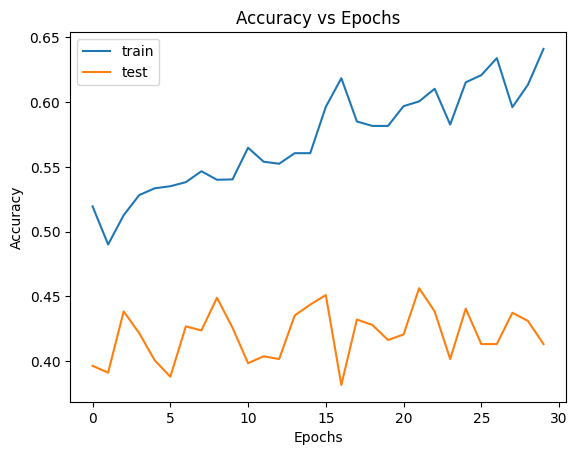

In [66]:
tf.random.set_seed(42)

history = dense_nn_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0, validation_data=(X_test, y_test))
plot_accuracy(history)

My optimized dense neural network utilizes 30 epochs, a batch size of 64, 7 dense layers, and the 'adam' optimizer. This achieved an accuracy of 40%, with a weighted average precision score of 0.40, recall of 0.40, and f1-score of 0.37. On the graph, you can also see that the training accuracy increased to around 60%.

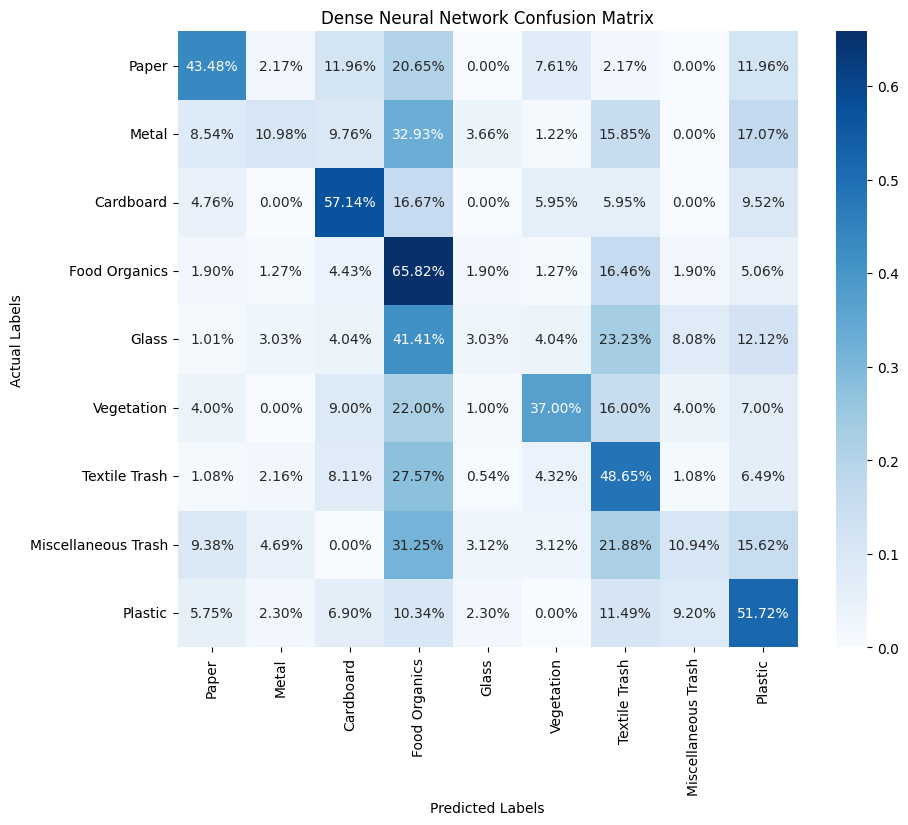

In [67]:
conf_matrix = confusion_matrix(y_test, dnn_pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Dense Neural Network Confusion Matrix')
plt.show()

From the confusion matrix, we can see that confusion between classes was prominent with glass and miscellaneous trash. On the other hand, food organics and cardboard decently well.

#### Optimizing Hyperparameters for Convolutional Neural Network

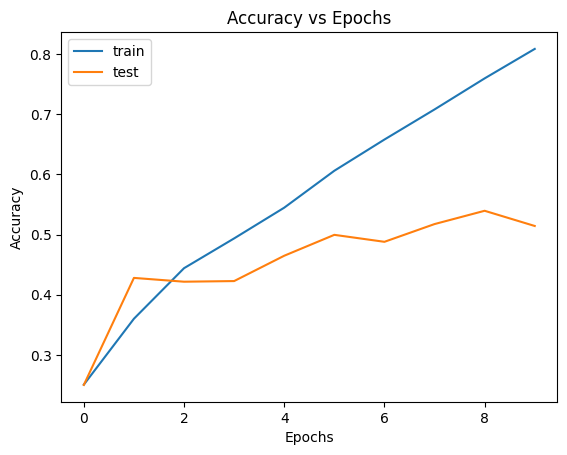

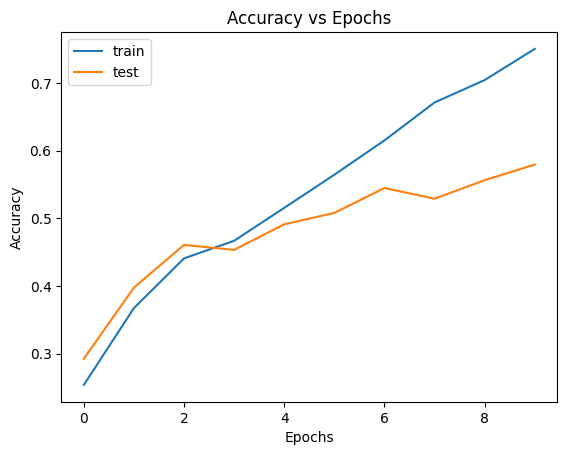

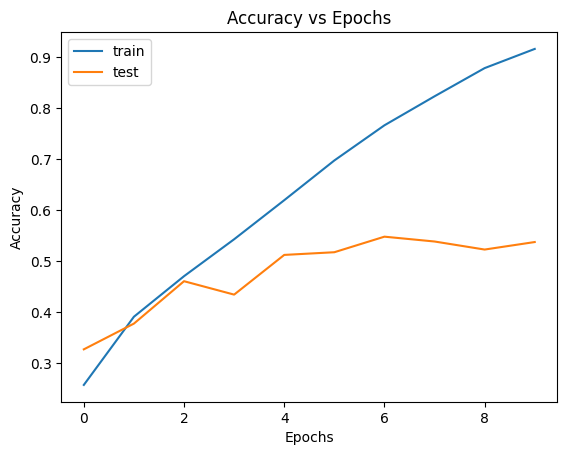

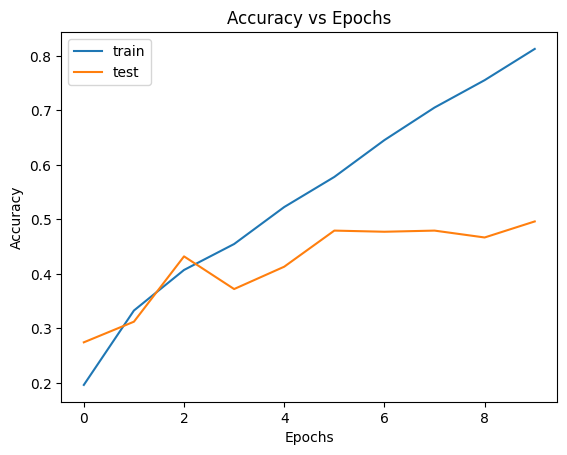

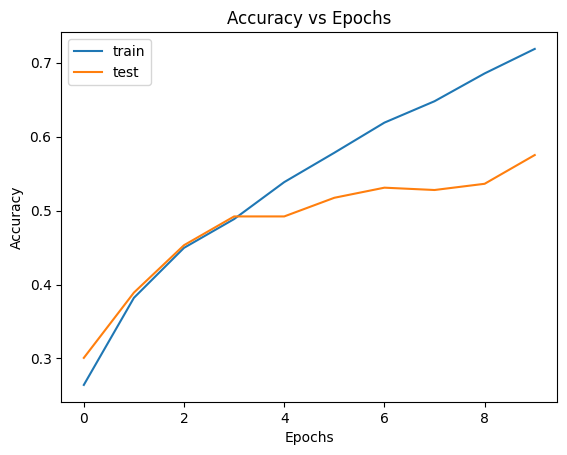

In [47]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tf.random.set_seed(42)

initial_num_conv_pool_layers = 2
initial_num_filters = 32
initial_filter_size = (3, 3)
initial_pool_size = (2, 2)

X_train_cnn = X_train.reshape(-1, 128, 128, 1)
X_test_cnn = X_test.reshape(-1, 128, 128, 1)

# Function for convolutional neural network
def cnn(num_conv_pool_layers=initial_num_conv_pool_layers, num_filters=initial_num_filters,
                         filter_size=initial_filter_size, pool_size=initial_pool_size):
    model = Sequential() # Initialize the Sequential model
    model.add(Conv2D(num_filters, filter_size, activation='relu', input_shape=(128, 128, 1))) # Add the first Conv2D layer
    model.add(MaxPooling2D(pool_size=pool_size)) # Add the first MaxPooling2D layer
    for _ in range(num_conv_pool_layers - 1):
        model.add(Conv2D(num_filters, filter_size, activation='relu')) # Add subsequent Conv2D and MaxPooling2D layers
        model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten()) # Add the Flatten layer
    model.add(Dense(128, activation='relu')) # Add the first Dense layer
    model.add(Dense(10, activation='softmax')) # Add the output Dense layer
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_cnn, y_test), verbose=0)
    return model, history

initial_cnn_model, initial_cnn_history = cnn()

# Initial configuration
plot_accuracy(initial_cnn_history)

# Changing number of convolutional/pooling layers
num_conv_pool_layers = 3
num_conv_pool_layers_cnn, num_conv_pool_layers_history = cnn(num_conv_pool_layers=num_conv_pool_layers)
plot_accuracy(num_conv_pool_layers_history)

# Changing number of filters
num_filters = 64
num_filters_cnn, num_filters_history = cnn(num_filters=num_filters)
plot_accuracy(num_filters_history)

# Changing filter size
filter_size = (4, 4)
filter_size_cnn, filter_size_history = cnn(filter_size=filter_size)
plot_accuracy(filter_size_history)

# Changing pool size
pool_size = (3, 3)
pool_size_cnn, pool_size_history = cnn(pool_size=pool_size)
plot_accuracy(pool_size_history)

The eighth and last model fitted is a convolutional neural network using a Sequential model. A convolutional neural network has a specialized deep learning architecture designed for processing structured grids of data, such as images. It uses convolutional layers to automatically and adaptively learn spatial hierarchies of features. Similar to the dense neural network model, our convolutional neural network has many parameters, making it difficult to make changes in the architecture using hyperparameter optimization. Thus, I will again fine-tune the following parameters: number of convolutional or pooling layers, number of filters, filter size, and pool size. First, I initialized the number of pooling layers as 2, the number of filters as 32, the filter size as (3, 3), and the pool size as (2, 2). I flattened the layers and added dense layers using ReLU and softmax activation. To compile the model, I used the sparse categorical cross entropy loss. In my accuracy plot for the initial configuration, the training accuracy was able to reach around 80%, but the testing accuracy stayed at around 50%. After increasing the number of pooling errors, the training accuracy decreased to around 70%, but the testing accuracy stayed at around 50%. If I increase the number of filters to 64, there is not much change in the training or testing accuracy. If I increase the filter size to (4, 4), the training and testing accuracy both seem to slightly decrease. Lastly, if I increase the pool size to (3, 3), the training accuracy seems to decrease to around 70% again, with the testing accuracy staying at around 50%. Now, I will implement the optimal features into my final convolutional neural network. Note: I altered each of the parameters with various different values, but just chose the most insightful ones for my analysis.

#### Convolutional Neural Network

In [48]:
# Optimized convolutional neural network

tf.random.set_seed(42)

cnn_model = Sequential() # Initialize the Sequential model
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1))) # Add the first Conv2D layer
cnn_model.add(MaxPooling2D((3, 3))) # Add the first MaxPooling2D layer
for _ in range(2):
    cnn_model.add(Conv2D(32, (3, 3), activation='relu')) # Add subsequent Conv2D and MaxPooling2D layers
    cnn_model.add(MaxPooling2D((3, 3)))
cnn_model.add(Flatten()) # Add the Flatten layer
cnn_model.add(Dense(128, activation='relu')) # Add the first Dense layer
cnn_model.add(Dense(10, activation='softmax')) # Add the output Dense layer

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, verbose=0)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)

30/30 [==============================] - 1s 17ms/step - loss: 1.3864 - accuracy: 0.5037


In [49]:
cnn_pred = np.argmax(cnn_model.predict(X_test), axis=1)
print("Convolutional Neural Network:")
print(classification_report(y_test, cnn_pred))

30/30 [==============================] - 1s 16ms/step
Convolutional Neural Network:
              precision    recall  f1-score   support

           0       0.51      0.57      0.54        92
           1       0.58      0.27      0.37        82
           2       0.77      0.44      0.56        84
           3       0.62      0.41      0.49       158
           4       0.33      0.34      0.34        99
           5       0.45      0.51      0.48       100
           6       0.52      0.66      0.58       185
           7       0.41      0.19      0.26        64
           8       0.47      0.97      0.64        87

    accuracy                           0.50       951
   macro avg       0.52      0.48      0.47       951
weighted avg       0.52      0.50      0.49       951



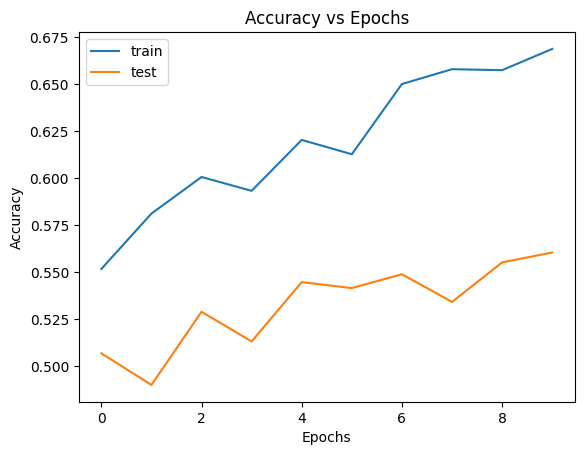

In [50]:
tf.random.set_seed(42)

history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, verbose=0, validation_data=(X_test_cnn, y_test))
plot_accuracy(history)

My optimized convolutional neural network utilizes 3 pooling layers, 32 filters, a filter size of (3, 3), and a pool size of (3, 3). This achieved an accuracy of 50%, with a weighted average precision score of 0.52, a recall of 0.50, and a f1-score of 0.49, all of which are slightly better than the convolutional neural network. On the graph, you can also see that the training accuracy was around 65%.

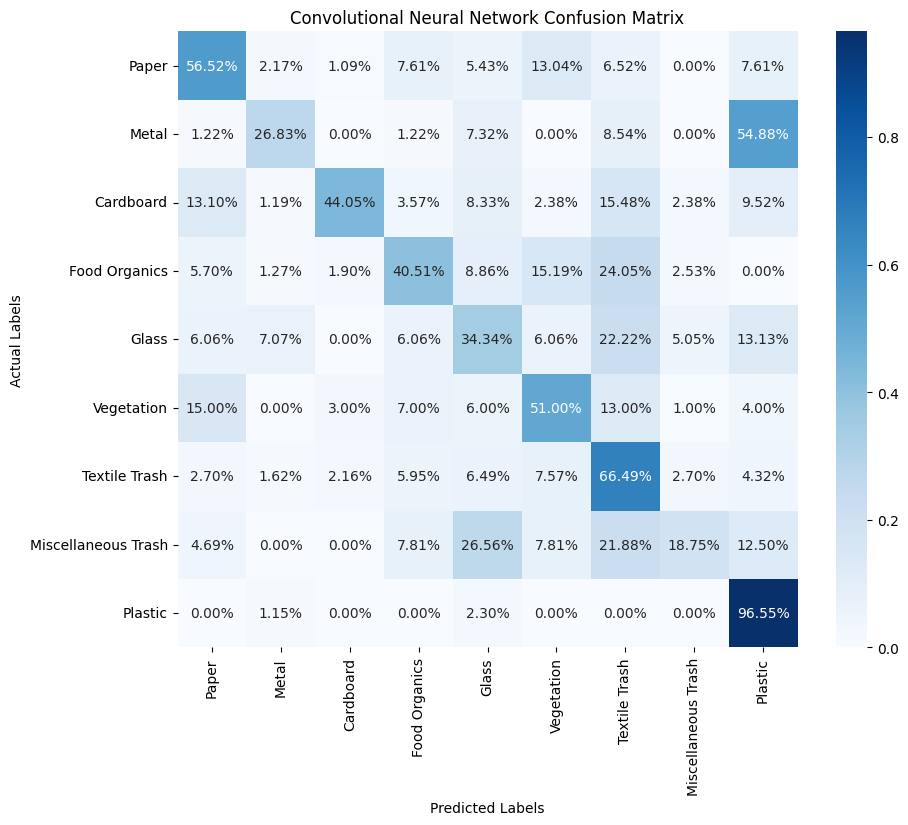

In [51]:
conf_matrix = confusion_matrix(y_test, cnn_pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Convolutional Neural Network Confusion Matrix')
plt.show()

Looking at the confusion matrix, we can see that confusion between classes was most significant with miscellaneous trash, while plastic performed exceptionally well, followed somewhat by textile trash.

#### Conclusion

Before jumping into a comparison of the results between the eight models, it is important to note the advantages and disadvantages of each algorithm. Logistic regression is easy to understand and is efficient for binary classification, however since my image classification task is a multi-class classification, this model may struggle with the data. Additionally, logistic regression has limited expressiveness for complex data like images and does not handle non-linear relationships well. Naive Bayes has fast and efficient training and can handle high-dimensional data well, but assumes independence between features which doesn't necessarily hold true for images and also has limited capability to capture complex relationships. Random forest is robust to overfitting due to ensemble averaging and is effective for handling high-dimensional data and feature interactions, but may require more computational resources for training and is less interpretable compared to simpler models like decision trees. K-nearest neighbors is also easy to understand and has no training phase, but is computationally expensive during inference especially for large datasets, and is sensitive to the choice of distance metric and the number of neighbors. Support vector machine is effective in high-dimensional spaces and is versatile due to the different kernel function (e.g. RBF), however it can be sensitive to the choice of kernel parameters and the training time can be extremely slow for large datasets (could not do cross validation). XGBoost has high predictive accuracy (achieved best accuracy for this model) and handles missing data well, although we did not have any. However, it requires careful tuning of hyperparameters and can be computationally expensive for large datasets (also could not do cross validation). Dense neural networks can learn complex patterns in data including images and has effective feature learning through multiple layers, however it is prone to overfitting especially with limited data and training can be computationally intensive, especially for deep architectures. Convolutional neural networks are highly effective for image classification tasks and automatically learns hierarchical features, but requires large amounts of labeled data for training and can be computationally expensive, especially for deeper architectures, similar to dense neural networks.

Now to compare our results from each of the models; XGBoost surprisingly performed best achieving an accuracy of 57%, beating out the convolutional neural network which achieved an accuracy of 50%. On the other end of the spectrum, logistic regression performed worst with an accuracy of 35%. XGBoost likely performed best due to its relatively decent performance in each class and because the model is known for its high predictive accuracy. The best performing classes were plastic with 79.31%, food organics with 69.62%, and textile trash with 68.11%, while the worst performing were miscellaneous trash with 26.56% and glass with 27.27%. To add on, this model did not have hyperparameter optimization, so there is still room for improvement. Random forest performed second best with an accuracy of 55%. The overall performance was not as good as XGBoost, but the plastic class performed extremely well at 88.51%. Support vector machine came third with a rather similar overall performance to random forest, with plastic performing extremely well at 81.41%, but miscellaneous trash performing very poorly at 9.38%. Similar to XGBoost, this model also still has room for improvement as its hyperparameters are not optimized. Both support vector machine and random forest are effective in high-dimensional spaces, which may explain their higher accuracies. Convolutional neural network surprisingly came fourth, even after trying to fine tune its hyperparameters, with an accuracy of 50%. Plastic achieved the highest accuracy across all models with a 96.55% accuracy, while miscellaneous trash struggled at around 18.75%. Fifth came the dense neural network, with an overall accuracy of 40%. This model performed decently for various classes like food organics, cardboard, plastic, and textile trash, but performed extremely poor on glass and miscellaneous trash. The convolutional neural network and dense neural network may have not performed as well due to the training being computationally expensive and having to adjust some parameters accordingly to optimize runtime. Sixth came K-nearest neighbors, achieving an accuracy of only 40%. This model did not perform too well, with the exception of the cardboard class having a 77.38% accuracy. Most notable are the plastic and metal accuracies with extremely low 5.75% and 4.88% accuracies respectively, both the lowest between all models. This may also be due to the computational cost of the algorithm, forcing the number of neighbors to be lower to optimize runtime. Naive Bayes came seventh with an accuracy of 38%, also performing not too well overall with cardboard performing best at 59.52% and glass performing worst at 14.14%. This algorithm has limited capability in capturing complex relationships, so it makes sense that it performed poorly on this dataset. Finally, logistic regression came last with an average overall accuracy of 35%, with cardboard performing best at 58.33% and miscellaneous trash performing joint worst at 9.38%. This image classification task was for multi-class classification rather than binary classification, so it makes sense that it comes in last for accuracy.

The accuracies of my models are rather poor when compared to the work of Sam Single, Saeid Iranmanesh, and Raad Raad in their honors thesis. Using the RealWaste data, they were able to achieve an accuracy of 89.19% using a convolutional neural network and the pre-trained InflectionV3 model. By using the InflectionV3 model or another pre-trained model, my accuracy for my convolutional neural network may have shot up, especially since it was just the miscellaneous class that was holding back the overall accuracy. However, I have decided to keep my modeling techniques within the scope of the class, and observe the highest accuracy from there.

Before closing off, it is essential to note the biases, interpretability, and ethics with respect to the data and algorithms that have been applied to it. One obvious bias is due to the class imbalance. With the plastic class having the most amount of images, there may be bias towards classifying plastic more accurately, especially after considering how the highest accuracies in the confusion matrices were often plastic. Another bias could be the fact that we are not given any information regarding the geographical location in which the images were taken and from where the waste was collected. If the model primarily learns from images of waste in urban areas, it may not perform as well for rural or suburban waste images. One last bias, although there are many more, could be from human subjectivity, coming from how each of the images were labeled into separate classes beforehand, which may impact the accuracy of the trained models. In terms of the interpretability of the data, there should not be too many problems, but in terms of the algorithms, such as the complex convolutional neural networks, they lack interpretability compared to simpler models like logistic regression or random forest, which may affect how one may interpret the results of the model. Lastly, in terms of ethics, an obvious question is regarding data privacy and how the images were collected and shared. Since this dataset includes waste such as paper, it may contain private information that should not be shared to the public without consent. Finally, it is important to consider the broader societal implications of waste classification algorithms, as automated waste sorting algorithms have potential in impacting employment in the future in recycling facilities or waste management factories.

To sum everything up, the XGBoost, support vector machine, and random forest models performed better than expected, while the convolutional neural network and dense neural performed worse than expected. XGBoost has high predictive accuracy, and support vector machine and random forest are effective in high-dimensional spaces, which likely explains their better performance compared to the other models tested. On the other hand convolutional neural network and dense neural network likely performed worse than expected due to the consideration of the adjustment of parameters based on optimizing runtime and minimizing computational cost. Nonetheless, in terms of the performance overall, the best algorithms performed only slightly better than flipping a coin, compared to Sam Single, Saeid Iranmanesh, and Raad Raad's research who achieved nearly 90% accuracy. In the future, if I were to expand on this project to achieve greater classification accuracies, it may be a good idea to try and apply pre-trained models, as well as consider expanding on the RealWaste dataset to first balance the image counts between classes, and then further refine the trained models by feeding in more images.